In [34]:
import pickle
import os
import numpy as np
import mdtraj
import deeptime
import glob
import matplotlib.pyplot as plt

# Will be needed to unpickle the TICA models
import sys
sys.path.append("..")

In [35]:
def load_trajectories(coordinate_files, size_limit=None):
    coordinate_list = []
    label_list = []

    for cf in coordinate_files:
        batch_label = os.path.basename(cf)
        batch_traj = []
        for subtraj in glob.glob(cf):
            if subtraj.endswith("npy"):
                coords = np.load(subtraj, allow_pickle=True)
                if type(coords) == dict: # One of Raz's benchmark archives
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-2:]))
                    batch_traj.extend(coords["mdtraj_list"])
                else: # A preprocess.py output file
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-3:]))
                    # Convert to NM to match mdtraj coordinates
                    coords = coords/10
                    psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
                    traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
                    batch_traj.append(traj)
            else: # Something mdtraj can open
                traj = mdtraj.load(subtraj)
                batch_traj.append(traj)
        if len(batch_traj) == 0:
            raise RuntimeError(f"{cf} did not match any files")
        
        batch_traj = mdtraj.join(batch_traj)

        # Select with a stride that brings the total number of frames down to the size_limit
        if size_limit and len(batch_traj) > size_limit:
            batch_traj = batch_traj[::(len(batch_traj)//size_limit)]

        label_list.append(batch_label)
        coordinate_list.append(batch_traj)

    assert len(coordinate_list) == len(label_list)
    return coordinate_list, label_list

def calculate_component_values(model, coordinates, components):
    # Returns an object of type list(dict(array)) : [trajectory, component, component_values_for_frames]
    component_values = {k: [] for k in components}

    pairs = np.vstack(np.triu_indices(coordinates.n_atoms, k=1)).T
    distances = mdtraj.compute_distances(coordinates, pairs)
    tica_comps = model.tica_model.transform(distances)
    for k, v in component_values.items():
        v.extend(tica_comps[:, k])

    return component_values

def shorten_label(label, maxlen):
    if len(label) > maxlen:
        return label[:maxlen-3] + "..."
    return label

### Configuration

In [36]:
model_filename = "/media/DATA_18_TB_1/andy/benchmark_cache/trpcage_300K.tica"

coordinate_files = [
    "/media/DATA_14_TB/daniel_s/cg_all_benchmark_finetuneE01_s4/trpcage*/raw/coordinates.npy",
    # "/media/DATA_18_TB_1/daniel_s/cgschnet/harmonic_net_2025.04.06/cg_high_density_benchmark_CA_only_2025.04.03_chignolin120_s100_CA_lj_bondNull_angleNull_dihedralNull/*/raw/coordinates.npy",
#     "/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_trpcage/westpa_prop/combined_trajs/trpcage_all.h5"
]

import re

def extract_number(filename):
    match = re.search(r'trpcage_(\d+)\.h5', filename)
    return int(match.group(1)) if match else float('inf')  # or 0 if you prefer


# Expand the glob pattern into a list
expanded_files = sorted(glob.glob(
    "/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_mix_trpcage_2d_mabbin/westpa_prop/combined_trajs/trpcage*.h5"
#     "/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_trpcage_2d/westpa_prop/combined_trajs/trpcage*.h5"
), key=extract_number)

# Append the matched files to the coordinate_files list
coordinate_files.extend(expanded_files)

with open(model_filename, 'rb') as f:
    model = pickle.load(f)
    assert hasattr(model, "tica_model")

coordinate_list, label_list = load_trajectories(coordinate_files, size_limit=1000000)
print(coordinate_list)

/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceKoopmanModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")


[<mdtraj.Trajectory with 995000 frames, 20 atoms, 20 residues, without unitcells at 0x7f71b390f910>, <mdtraj.Trajectory with 50 frames, 20 atoms, 20 residues, without unitcells at 0x7f756b601890>, <mdtraj.Trajectory with 300 frames, 20 atoms, 20 residues, without unitcells at 0x7f7570299890>, <mdtraj.Trajectory with 1450 frames, 20 atoms, 20 residues, without unitcells at 0x7f757027ea90>, <mdtraj.Trajectory with 5600 frames, 20 atoms, 20 residues, without unitcells at 0x7f756bd35110>, <mdtraj.Trajectory with 13700 frames, 20 atoms, 20 residues, without unitcells at 0x7f756b58be50>, <mdtraj.Trajectory with 24250 frames, 20 atoms, 20 residues, without unitcells at 0x7f756bee8e10>, <mdtraj.Trajectory with 33600 frames, 20 atoms, 20 residues, without unitcells at 0x7f757025a090>, <mdtraj.Trajectory with 43750 frames, 20 atoms, 20 residues, without unitcells at 0x7f756b6ca450>, <mdtraj.Trajectory with 54750 frames, 20 atoms, 20 residues, without unitcells at 0x7f7570274f50>, <mdtraj.Traject

In [37]:
components_to_calculate = range(2)
tica_plot_pad = 0.2

kB = 0.0019872041 # kcal/mol/Kelvin
Temp = 300 # Kelvin

In [38]:
component_values = [calculate_component_values(model, c, components_to_calculate) for c in coordinate_list]
component_values[0].keys(), [[len(v) for v in c.values()] for c in component_values]

component_maxs = [max([max(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_mins = [min([min(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_range = [*zip(component_mins, component_maxs)]

print(component_values[0].keys(), [[len(v) for v in c.values()] for c in component_values])
print("range:", component_range)

dict_keys([0, 1]) [[995000, 995000], [50, 50], [300, 300], [1450, 1450], [5600, 5600], [13700, 13700], [24250, 24250], [33600, 33600], [43750, 43750], [54750, 54750], [66300, 66300], [77600, 77600], [88050, 88050], [99150, 99150], [107750, 107750], [107750, 107750]]
range: [(-1.4919814151108817, 1.6250494482223619), (-3.6071033730566104, 2.329910871398848)]


### Contour Plots

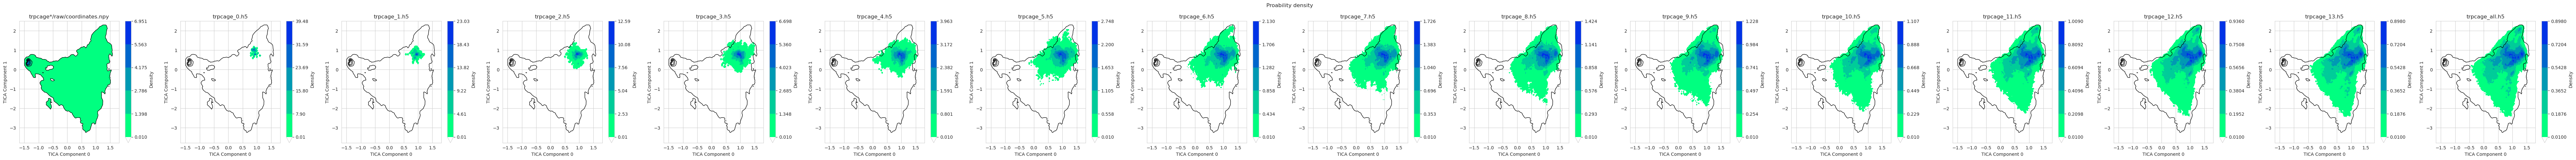

In [39]:
histogram_range = np.array([[component_range[0][0] - tica_plot_pad, component_range[0][1] + tica_plot_pad],
                            [component_range[1][0] - tica_plot_pad, component_range[1][1] + tica_plot_pad]])
num_contour_levels = 6

# TODO: Use grid function from bond/angle notebook
fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5))
if len(coordinate_list) == 1:
    axes = [axes]
hist_ref = None
levels_ref = None

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

#     levels = np.linspace(0.01, round(np.max(hist2d)*1.1, 1), num_contour_levels)

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)  # fallback for low density
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    if hist_ref is None:
        hist_ref = hist2d
        levels_ref = levels


    contour1 = axes[i].contourf(hist2d.T, origin='lower', extent=histogram_range.flatten(), levels=levels, extend='min',
                                colors=[(0.0,0.0,0.0,0.0)]+[plt.cm.winter_r(i/(len(levels)-1)) for i in range(len(levels)-1)])
    axes[i].contour(hist_ref.T, origin='lower', extent=histogram_range.flatten(), levels=levels_ref, colors="black", linewidths=1, linestyles="-")
    axes[i].set_xlabel('TICA Component 0')
    axes[i].set_ylabel('TICA Component 1')
    fig.colorbar(contour1, ax=axes[i], label='Density')
    axes[i].set_title(shorten_label(label_list[i], 50))

fig.suptitle("Proability density")
plt.tight_layout()
plt.show()


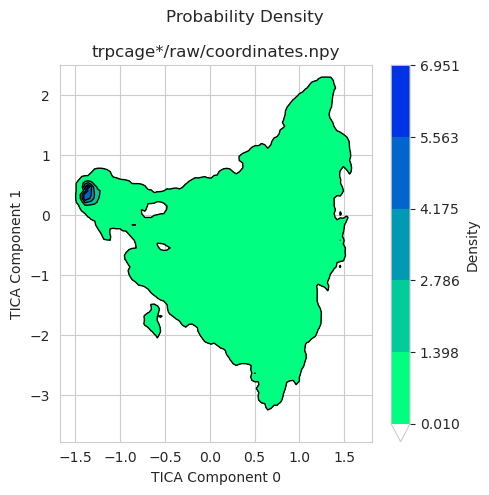

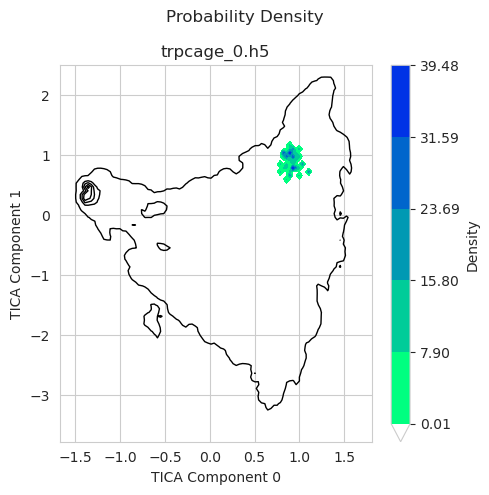

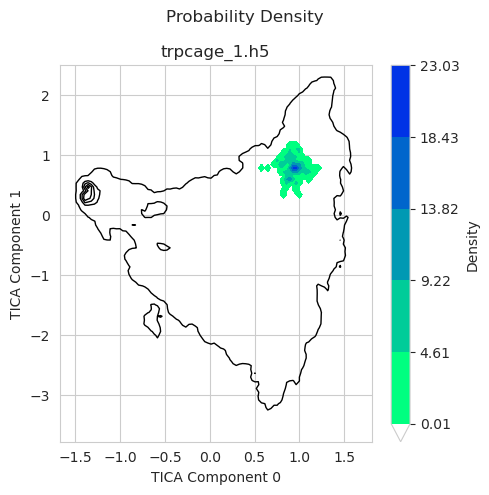

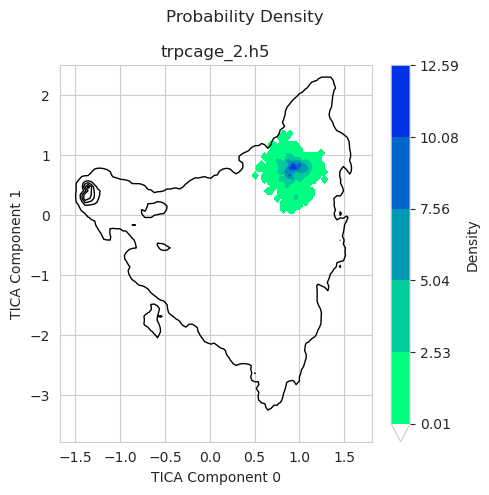

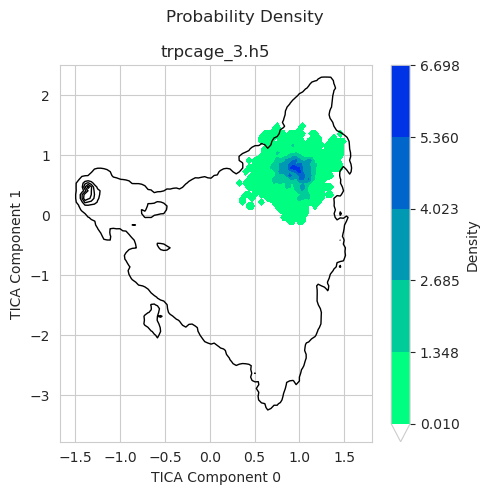

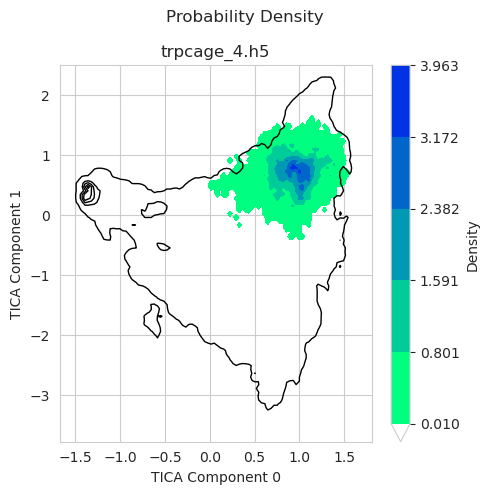

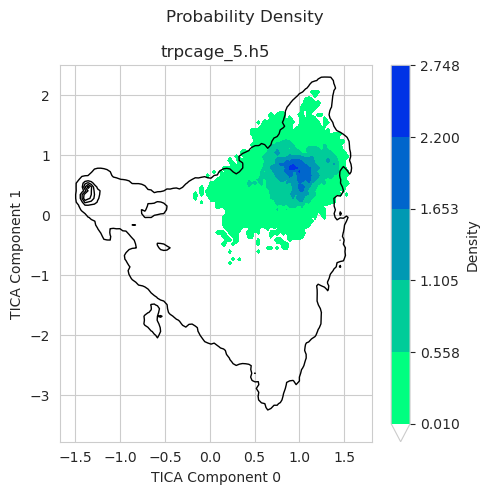

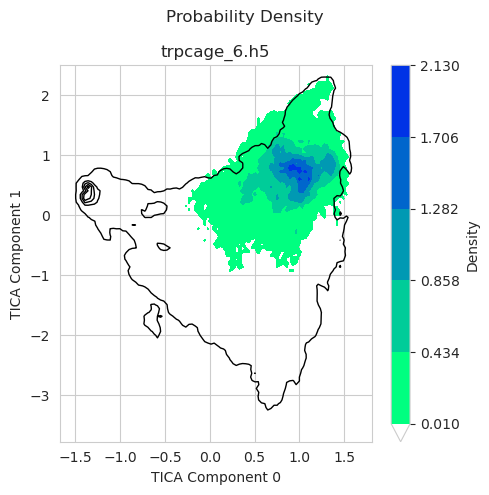

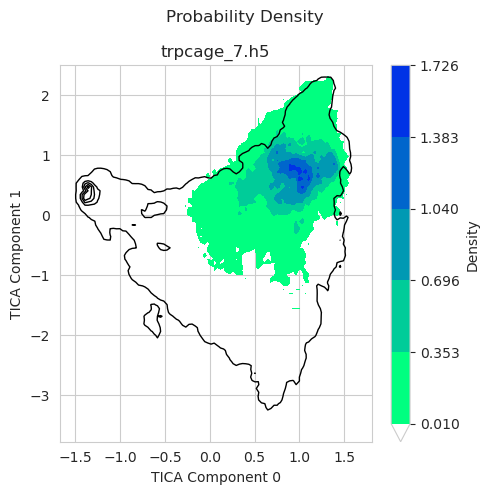

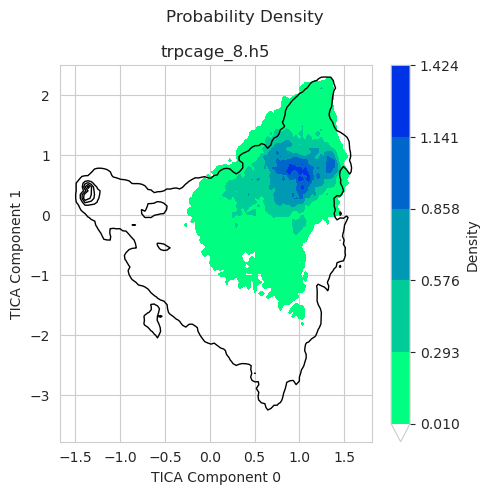

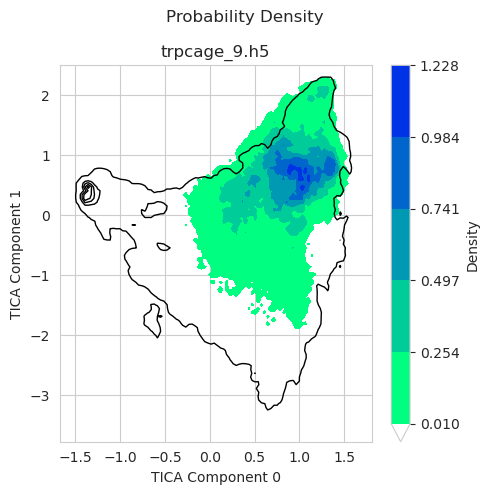

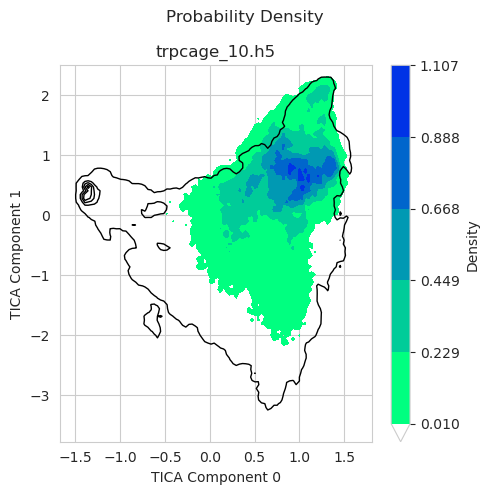

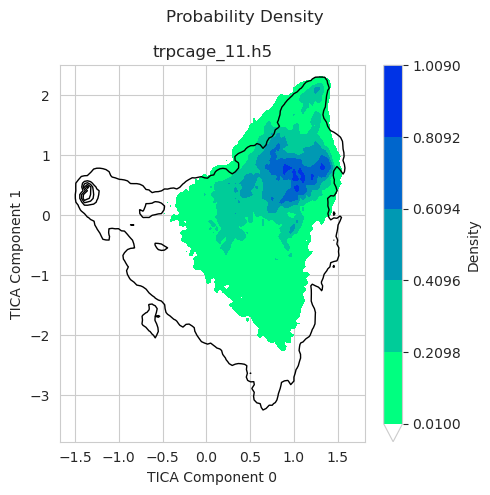

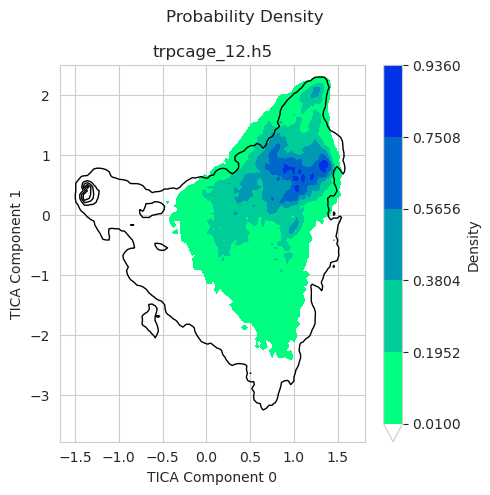

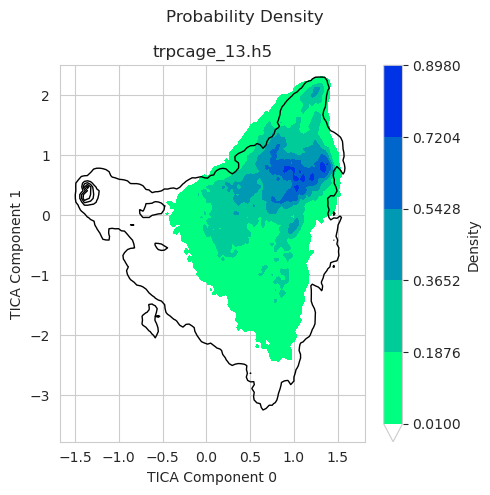

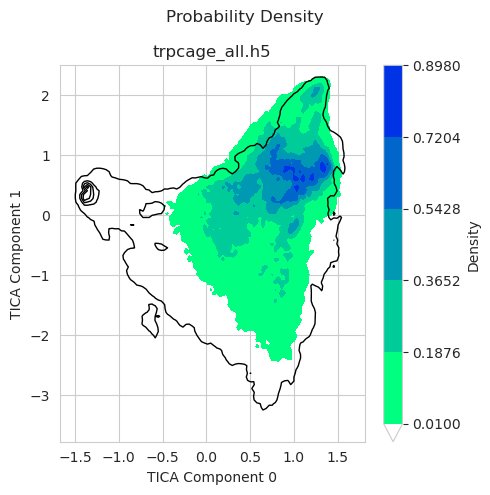

In [40]:
for i in range(len(coordinate_list)):
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a new figure for each plot

    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    if i == 0:
        hist_ref = hist2d
        levels_ref = levels

    contour = ax.contourf(
        hist2d.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels,
        extend='min',
        colors=[(0.0, 0.0, 0.0, 0.0)] + [plt.cm.winter_r(j / (len(levels) - 1)) for j in range(len(levels) - 1)],
    )

    ax.contour(
        hist_ref.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels_ref,
        colors="black",
        linewidths=1,
        linestyles="-"
    )

    ax.set_xlabel('TICA Component 0')
    ax.set_ylabel('TICA Component 1')
    fig.colorbar(contour, ax=ax, label='Density')
    ax.set_title(shorten_label(label_list[i], 50))

    fig.suptitle("Probability Density")
    plt.tight_layout()
    plt.show()


2025-05-30 22:14:04,469 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-05-30 22:14:04,470 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y density_movie.mp4
/tmp/ipykernel_1718115/2569888434.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return contour.collections


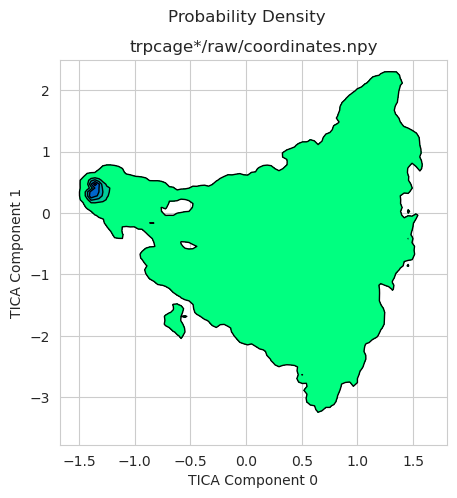

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(5, 5))

# Prepare the first frame manually
hist_ref = None
levels_ref = None

# Store all 2D histograms and levels ahead of time
histograms = []
levels_list = []

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    histograms.append(hist2d)
    levels_list.append(levels)

    if i == 0:
        hist_ref = hist2d
        levels_ref = levels

# Function to update the frame
def update(i):
    ax.clear()

    hist2d = histograms[i]
    levels = levels_list[i]

    contour = ax.contourf(
        hist2d.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels,
        extend='min',
        colors=[(0.0, 0.0, 0.0, 0.0)] + [plt.cm.winter_r(j / (len(levels) - 1)) for j in range(len(levels) - 1)],
    )

    ax.contour(
        hist_ref.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels_ref,
        colors="black",
        linewidths=1,
        linestyles="-"
    )

    ax.set_xlabel('TICA Component 0')
    ax.set_ylabel('TICA Component 1')
    ax.set_title(shorten_label(label_list[i], 50))
    fig.suptitle("Probability Density")
    return contour.collections

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(coordinate_list), blit=False
)

# Save animation to file
ani.save("density_movie.mp4", writer='ffmpeg', fps=10)  # Adjust `fps` as needed


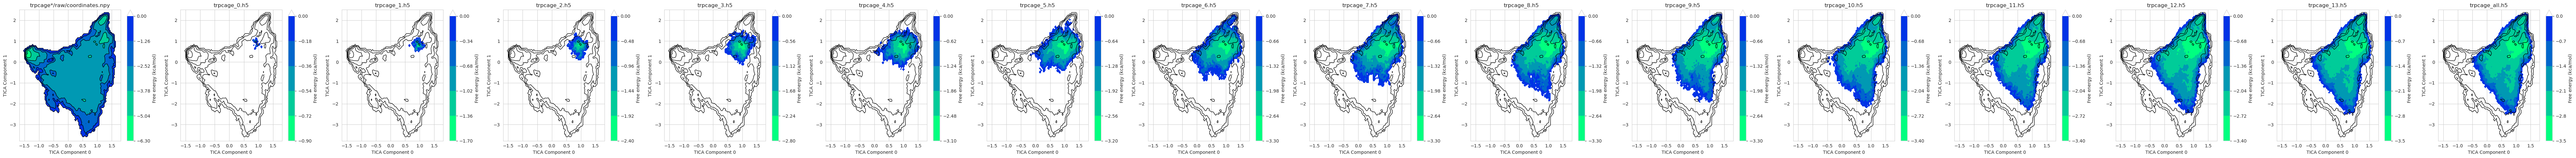

In [27]:
histogram_range = np.array([[component_range[0][0] - tica_plot_pad, component_range[0][1] + tica_plot_pad],
                            [component_range[1][0] - tica_plot_pad, component_range[1][1] + tica_plot_pad]])

# TODO: Use grid function from bond/angle notebook
fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5))
if len(coordinate_list) == 1:
    axes = [axes]
hist_ref = None

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
    )

    hist_log_mask = hist2d > 0
    hist2d[hist_log_mask] = -kB * Temp * np.log(hist2d[hist2d > 0])
    hist2d[~hist_log_mask] = 0.0000001 # The histograms look nicer if the undefined values are slightly more than zero

    levels=np.linspace(round(np.min(hist2d)*1.1, 1), 0, num_contour_levels)

    if hist_ref is None:
        hist_ref = hist2d
        levels_ref = levels

    contour1 = axes[i].contourf(hist2d.T, origin='lower', extent=histogram_range.flatten(), levels=levels, extend='max',
                                colors=[plt.cm.winter_r(i/(len(levels)-1)) for i in range(len(levels)-1)]+[(0.0,0.0,0.0,0.0)])
    axes[i].contour(hist_ref.T, origin='lower', extent=histogram_range.flatten(), levels=levels_ref, colors="black", linewidths=1, linestyles="-")
    axes[i].set_xlabel('TICA Component 0')
    axes[i].set_ylabel('TICA Component 1')
    fig.colorbar(contour1, ax=axes[i], label='Free energy (kca/mol)')
    axes[i].set_title(shorten_label(label_list[i], 50))

plt.tight_layout()
plt.show()


### Component Plots

In [ ]:
for comp_idx in component_values[0].keys():
    # TODO: Use grid function
    fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5), sharey=True)
    if len(coordinate_list) == 1:
        axes = [axes]
    hist_ref_x = None

    for i in range(len(coordinate_list)):
        hist, bin_edges = np.histogram(
            component_values[i][comp_idx],
            bins=100,
        )

        hist_mask = hist > 0
        hist_y = -kB * Temp * np.log(hist[hist_mask])
        hist_x = ((bin_edges[1:]+bin_edges[:-1])/2)[hist_mask]

        if hist_ref_x is None:
            hist_ref_x = hist_x
            hist_ref_y = hist_y

        axes[i].plot(hist_ref_x, hist_ref_y)
        axes[i].plot(hist_x, hist_y)
        axes[i].set_title(shorten_label(label_list[i], 50))
        
    fig.suptitle(f"TICA Component {comp_idx} Energy")
    axes[0].set_ylabel('Free energy (kca/mol)')

    plt.tight_layout()
    plt.show()

In [ ]:
for comp_idx in component_values[0].keys():
    # TODO: Use grid function
    fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5), sharey=True)
    if len(coordinate_list) == 1:
        axes = [axes]
    hist_ref_x = None

    for i in range(len(coordinate_list)):
        hist, bin_edges = np.histogram(
            component_values[i][comp_idx],
            bins=100,
            density=True,
        )

        hist_y = hist
        hist_x = ((bin_edges[1:]+bin_edges[:-1])/2)

        if hist_ref_x is None:
            hist_ref_x = hist_x
            hist_ref_y = hist_y

        axes[i].plot(hist_ref_x, hist_ref_y)
        axes[i].plot(hist_x, hist_y)
        axes[i].set_title(shorten_label(label_list[i], 50))
        
    fig.suptitle(f"TICA Component {comp_idx} Density")
    axes[0].set_ylabel('Probability Density')

    plt.tight_layout()
    plt.show()